## Goal is to predict or classify Life Expectancy
- We want to first determine which variables are useful

In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

data_raw = pd.read_csv("/Users/rishabtirupathi/Desktop/UIUC/Spring 2024/STAT 432/Final Project/Life Expectancy Data.csv")
country_list = sorted(list(set((data_raw['Country']))))
data_raw.columns = [i.strip() for i in data_raw.columns]

colours = random.sample(list(mcolors.XKCD_COLORS.keys()), len(country_list))

data_raw.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


#### Data preprocessing
- Determine any missing data, linearly interpolate them
- Use correlation analysis to determine which features to use

/var/folders/68/886mn3q57q9f6lcdshz9b8j80000gn/T/ipykernel_6354/2460753164.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method = 'linear')


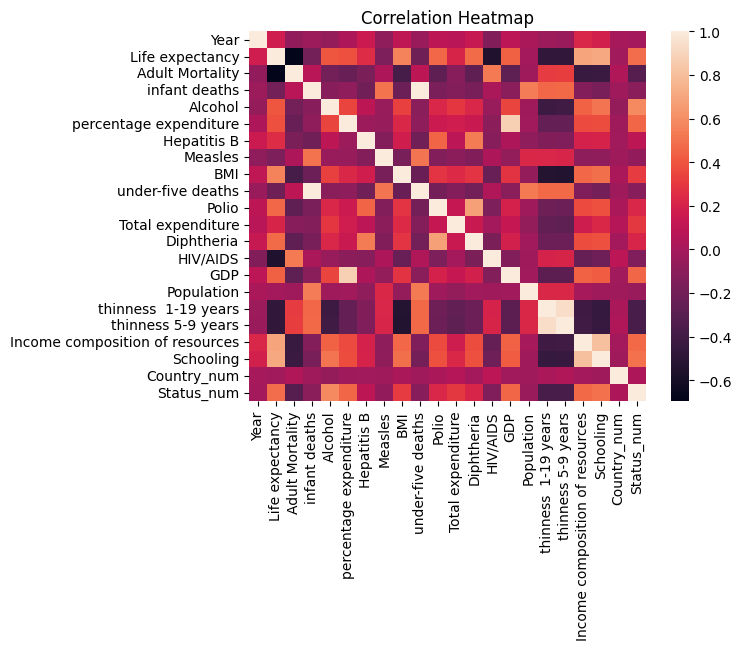

,Column,Correlation
1,Life expectancy,1.000000
2,Adult Mortality,-0.695730
4,Alcohol,0.400319
8,BMI,0.556433
10,Polio,0.459865
12,Diphtheria,0.474084
13,HIV/AIDS,-0.555929
14,GDP,0.436281
16,thinness 1-19 years,-0.476809
17,thinness 5-9 years,-0.472485


In [171]:
df = data_raw.copy()

## Make categorical variables in quantitative
df['Country_num'] = df['Country'].apply(lambda x: country_list.index(x) + 1)
df['Status_num'] = df['Status'].apply(lambda x: 0 if x == 'Developing' else 1)
df['Colour'] = df['Country'].apply(lambda x: colours[country_list.index(x)])

df = df.interpolate(method = 'linear')

corr_df = df.drop(columns=['Country', 'Status', 'Colour']).corr()
sns.heatmap(corr_df)
plt.title("Correlation Heatmap")
plt.show()

## Consider the values which have |r| high enough (arbitrary)
life_expectancy_corr = pd.DataFrame({"Column": corr_df.loc["Life expectancy"].index, "Correlation": corr_df.loc["Life expectancy"].values})
life_exp_var = life_expectancy_corr[abs(life_expectancy_corr['Correlation']) >= 0.4]
life_exp_var

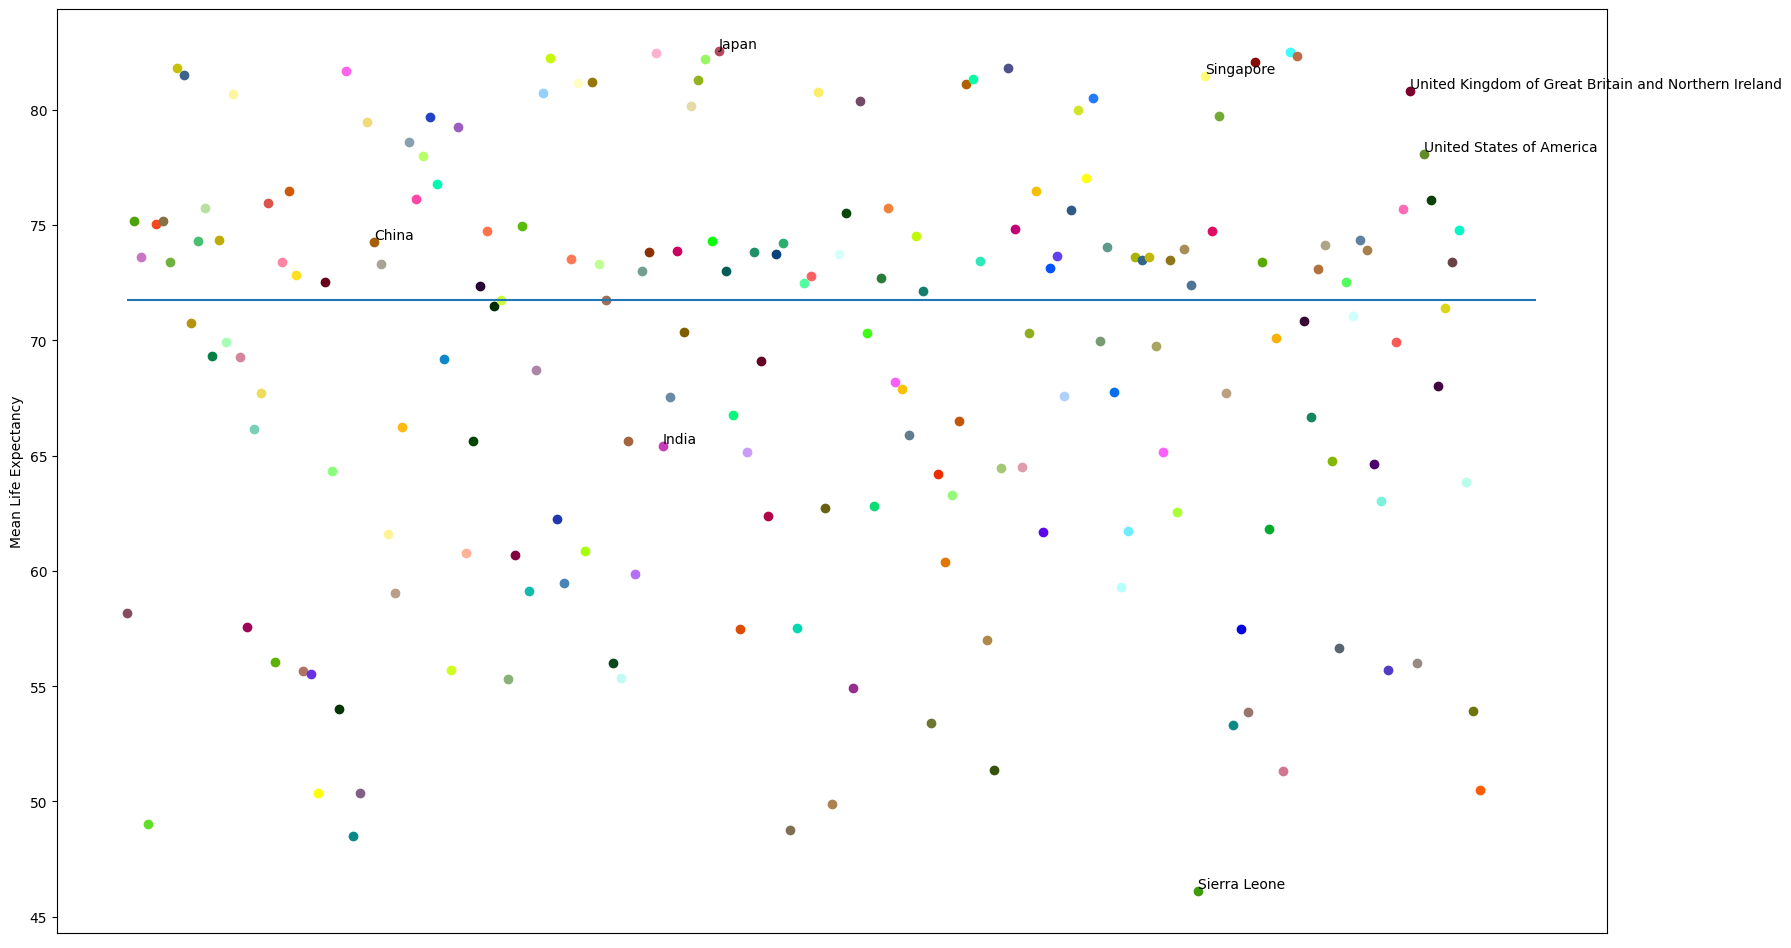

In [172]:
df['Mean LE'] = df.groupby(by = 'Country')['Life expectancy'].transform('mean')
trunc_df = df.copy()
trunc_df = trunc_df[['Country', 'Mean LE', 'Colour']].drop_duplicates().reset_index(drop = True)
key_countries = ['United States of America', 'United Kingdom of Great Britain and Northern Ireland', 'Singapore', 'India', 'China']
max_mle = max(trunc_df['Mean LE'])
min_mle = min(trunc_df['Mean LE'])

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 12))
for country, mean_le, colour in zip(trunc_df['Country'], trunc_df['Mean LE'], trunc_df['Colour']):
    axes.scatter(country, mean_le, c = colour, label = country)

    if country in key_countries or mean_le in [max_mle, min_mle]:
        plt.text(country, mean_le, country, va = 'bottom')

axes.set_xticks([])
axes.set_ylabel("Mean Life Expectancy")
axes.hlines(y = trunc_df['Mean LE'].median(), xmin = 0, xmax = 200)
# axes.legend()
plt.show()

#### Describe life expectancy to determine how to class it

In [173]:
df['Life expectancy'].describe()

count    2938.000000
mean       69.214874
std         9.510819
min        36.300000
25%        63.100000
50%        72.000000
75%        75.600000
max        89.000000
Name: Life expectancy, dtype: float64

#### Logistic Regression
- Because Logistic regression is a classification problem, the output needs to be categorical
- Encode life expectancy as <25% (63.1) as low, 25 - 75 (63.1 - 75.6) as medium, >75% (75.6) as high

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


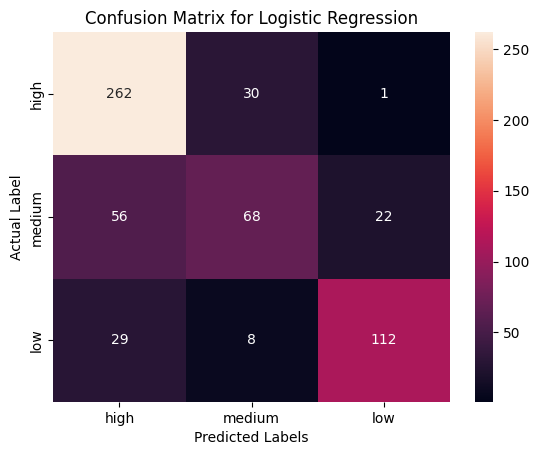

Classification Error = 0.2482993197278912


In [181]:
np.random.seed(42)

pred = list(life_exp_var[life_exp_var['Column'] != 'Life expectancy']['Column'])
model_df = df.copy()

## Bounds for low, medium, high expectancy
q1 = df['Life expectancy'].describe().loc['25%']
q2 = df['Life expectancy'].describe().loc['50%']
q3 = df['Life expectancy'].describe().loc['75%']

model_df['Life expectancy'] = model_df['Life expectancy'].apply(lambda x: "low" if x < q1 else('medium' if x <= q2 else 'high'))

X, y = model_df[pred], model_df['Life expectancy']

## Split train and test
shuffle_df = model_df.sample(frac=1)
train_idx = int(0.8 * len(shuffle_df))

train_data, test_data = shuffle_df.head(train_idx), shuffle_df.tail(len(shuffle_df) - train_idx)

X_train, y_train = train_data[pred], train_data['Life expectancy']
X_test, y_test = test_data[pred], test_data['Life expectancy']

# Construct model
log_mod = LogisticRegression(random_state = 4)
log_mod.fit(X_train, y_train)
y_pred = log_mod.predict(X_test)

## Combine results in df
results = pd.DataFrame({"Country": test_data['Country'], "Year": test_data['Year'], "Prediction": y_pred, "Actual": y_test})

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = ['high', 'medium', 'low'])
sns.heatmap(conf_matrix, annot = True, fmt = 'g')
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Logistic Regression")
plt.xticks(ticks = [0.5, 1.5, 2.5], labels=['high', 'medium', 'low'])
plt.yticks(ticks = [0.5, 1.5, 2.5], labels=['high', 'medium', 'low'])
plt.show()

classification_error = 1-(sum(np.diag(conf_matrix))/sum(sum(conf_matrix)))

print("Classification Error =", classification_error)

#### Random Forest